### Linguistic and structural analysis
 
1. Preprocessing

Standard text preprocessing steps were applied to ensure data quality and consistency:

- Tokenization of titles 
- Lowercasing of text  
- Removal of stopwords, special characters, and non-informative tokens  
- Deduplication of near-identical entries  


NLP Techniques


1. **Part-of-Speech (POS) Tagging**  
  Identifies grammatical roles and recurring syntactic patterns.
  
1. **Dependency Parsing**  
  Examines how **gendered** and **racialized** terms are positioned within phrases, revealing structural relationships.

1. **Bigram and Trigram Modeling**  
  Captures frequently occurring word sequences and stereotypical expressions.



In [1]:
import pandas as pd
from collections import Counter
import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean

import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/home/olga/Documents/eur-porntypes/stereotype-map/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Curated list of nouns and adjectives

In [2]:
from typing import Set

SMALL_ADJECTIVES: Set[str] = {"small", "tiny", "petite", "little", "slim", "narrow", "tight", "skinny", "mini", "wee", "diminutive", "compact", "slender", "short"}
LARGE_ADJECTIVES: Set[str] = {"big", "large", "huge", "giant", "massive", "thick", "broad", "wide", "enormous", "colossal", "immense", "vast", "tall", "long"}

FEMALE_NOUNS: Set[str] = {"girl", "babe" "woman", "wife", "mom", "lady", "female", "daughter", "sister", "mother", "girlfriend", "teen", "housewife", "bride", "mistress", "goddess", "queen", "princess", "she"}
MALE_NOUNS: Set[str] = {"boy", "man", "husband", "dad", "guy", "male", "brother", "son", "dude", "boyfriend", "groom", "prince", "king", "stud", "gentleman", "hero", "beast", "champion", "legend", "he"} 
                        
APPEARANCE_ADJECTIVES: Set[str] = {
    "hot", "sexy", "cute", "beautiful", "blonde", "busty", "naughty", "attractive", "pretty", "gorgeous", "slim", "curvy", "slender"
}

ROLE_ACTION_ADJECTIVES: Set[str] = {
    "dominant", "experienced", "aggressive", "first", "young", "mature", "amateur", "professional", "hardcore", "wild"}

PLACE_NOUNS: Set[str] = {
    "kitchen", "bathroom", "school", "hotel", "car", "office", "beach", "classroom",
    "park", "gym", "public", "bedroom", "club", "bus", "library", "shower"
}

RACIALIZED_TERMS: Set[str] = {"black", "asian", "eboni", "white", "latina", "german", "french", "russian", "spanish", "italian",
    "indian", "dark", "british", "brazilian", "korean", "european", "brown", "thai", "african", "orient",
    "arab", "english", "muslim", "canadian", "hungarian"}

STEREOTYPED_TERMS = {
    "body": {"tit", "boob", "pussy", "ass", "cock", "dick"},
    "age": {"teen", "mature", "young", "old"},
    "race": {"black", "asian", "eboni", "white", "latina", "german", "french", "russian", "spanish", "italian",
    "indian", "dark", "british", "brazilian", "korean", "european", "brown", "thai", "african", "orient",
    "arab", "english", "muslim", "canadian", "hungarian"},
    "role": {"slut", "milf", "stepmom", "stepson", "whore"}
}


#### Load pornhub dataset

In [3]:
columns_to_read = [
    "url",
    "title",
    "categories",
    "date",
    "views",
    "upvotes"
  ]

df = pd.read_csv("data/raw/data2008-2024.csv", usecols=columns_to_read)
df.tail(25)

,url,title,categories,date,views,upvotes
256101,https://www.pornhub.com/view_video.php?viewkey...,BANGBROS - Brother Goes Deep in Step Sister Aa...,"['Anal', 'Babe', 'Big Ass', 'Big Tits', 'HD Po...",2017-10-18,NaN,NaN
256102,https://www.pornhub.com/view_video.php?viewkey...,Ele queria jogar video game e eu queria dar o ...,"['Amateur', 'Anal', 'Big Ass', 'Brazilian', 'H...",2024-07-14,NaN,NaN
256103,https://www.pornhub.com/view_video.php?viewkey...,Throat dragon Latina gets pounded by BWC,"['18-25', 'Big Ass', 'Big Dick', 'Blowjob', 'C...",2023-01-27,NaN,NaN
256104,https://www.pornhub.com/view_video.php?viewkey...,busty horny mom,"['Big Tits', 'MILF', 'Mature']",2012-07-06,NaN,NaN
256105,https://www.pornhub.com/view_video.php?viewkey...,Fingering my wet pussy in leather mini skirt a...,"['18-25', 'Big Tits', 'Brunette', 'Exclusive',...",2020-10-17,NaN,NaN
256106,https://www.pornhub.com/view_video.php?viewkey...,DOEGIRLS - Sexy Big Tits Blonde Kaisa Nord Rid...,"['Babe', 'Big Ass', 'Big Tits', 'Female Orgasm...",2022-08-20,NaN,NaN
256107,https://www.pornhub.com/view_video.php?viewkey...,Boyfriends Bareback Cum Compilation - Vol 1,"['Amateur', 'Bareback', 'Big Dick', 'Compilati...",2021-06-05,NaN,NaN
256108,https://www.pornhub.com/view_video.php?viewkey...,【盗撮】貧乳女子にバレないように隠し撮りする Japanese,"['Amateur', 'Babe', 'Blowjob', 'Exclusive', 'H...",2022-01-15,NaN,NaN
256109,https://www.pornhub.com/view_video.php?viewkey...,Giochi di specchi - Da sola a casa mi masturbo...,"['Amateur', 'Big Ass', 'Female Orgasm', 'HD Po...",2021-06-12,5400.0,46.0
256110,https://www.pornhub.com/view_video.php?viewkey...,Busty MILF Brought Home Mistress to Play,"['Babe', 'Big Ass', 'Big Tits', 'FFM in Threes...",2020-03-22,NaN,NaN


In [5]:
import os
plot_output_path = "plots"
data_output_path = "data/processed"

os.makedirs(plot_output_path, exist_ok=True)  # ensure the folder exists
os.makedirs(data_output_path, exist_ok=True)  

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
pd.to_datetime(df.date).max()


Timestamp('2024-08-08 00:00:00')

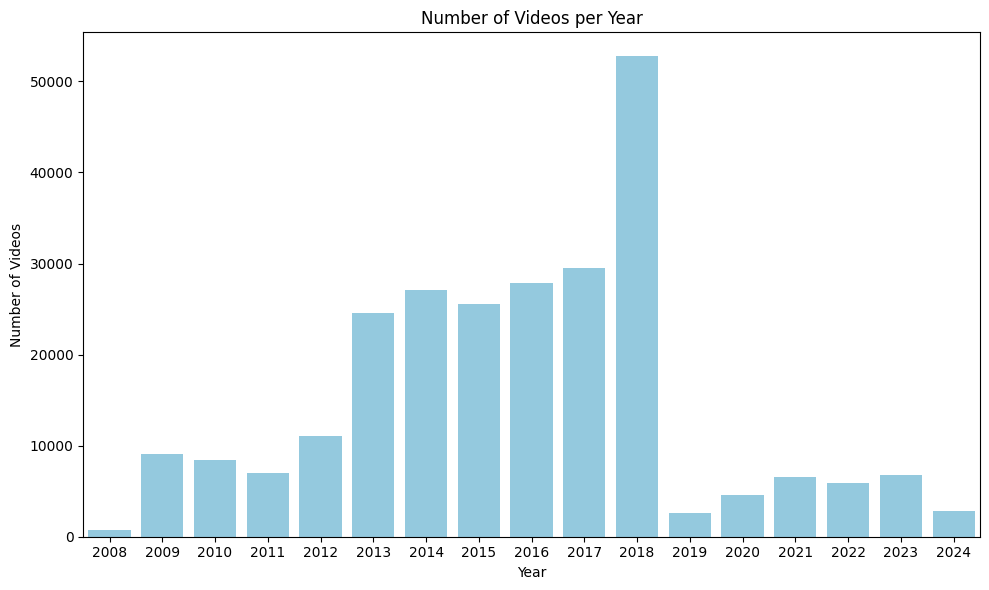

In [7]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

videos_per_year = df["year"].value_counts().sort_index()

# Plot number of videos per year
plt.figure(figsize=(10, 6))
sns.barplot(x=videos_per_year.index.astype(int), y=videos_per_year.values, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Year")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path, "videos_per_year.png"), bbox_inches="tight")
plt.show()

In [8]:
# Statistics on the counts (number of videos per year)
mean_count = videos_per_year.mean()
std_count = videos_per_year.std()
min_count = videos_per_year.min()
max_count = videos_per_year.max()

print(f"Minimum videos in a year: {min_count}")
print(f"Maximum videos in a year: {max_count}")
print(f"Mean videos per year: {mean_count:.2f}")
print(f"Standard deviation of videos per year: {std_count:.2f}")

Minimum videos in a year: 763
Maximum videos in a year: 52746
Mean videos per year: 14881.35
Standard deviation of videos per year: 14023.94


#### Adjective noun pairs in titles



In [9]:
# Calculate title lengths
df["title_length"] = df["title"].astype(str).apply(len)

# Get statistics
mean_length = df["title_length"].mean()
median_length = df["title_length"].median()
std_length = df["title_length"].std()
min_length = df["title_length"].min()
max_length = df["title_length"].max()

print(f"Mean title length: {mean_length:.2f}")
print(f"Median title length: {median_length}")
print(f"Standard deviation: {std_length:.2f}")
print(f"Min title length: {min_length}")
print(f"Max title length: {max_length}")

Mean title length: 40.78
Median title length: 39.0
Standard deviation: 17.54
Min title length: 1
Max title length: 102


In [10]:
from src.models import embeddings

embeddings.download_nltk_data()

# Ensure all titles are strings and fill NaN with empty string
df["title"] = df["title"].fillna("").astype(str)

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_tokenize_and_stem)

# Flatten the list of words and count frequencies
all_words = [word for words in df["title_words"] for word in words]
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=["word", "count"])



[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df.title_words

0                           [cute, teen, gloryhol, handjob]
1         [reali, nice, step, mom, angi, give, titjob, g...
2                               [step, mom, gift, son, pov]
3                       [baltimor, street, hooker, creampi]
4                           [cute, blond, brunett, pleasur]
                                ...                        
256121                                      [video, disabl]
256122                                      [famou, youtub]
256123                              [finger, squirt, pussi]
256124    [esposa, le, entrega, el, culo, su, vecino, lo...
256125                 [mädchen, masturbiert, im, solarium]
Name: title_words, Length: 256126, dtype: object

In [11]:
df["title"]

0                               Cute teen gloryhole handjob
1         Realy Nice Step Mom Angie Gives Titjob Good Yo...
2                             Step Mom´s gift for son - pov
3                          Baltimore Street Hooker Creampie
4              Cute Blonde and Brunette Pleasure Each Other
                                ...                        
256121                                       Video Disabled
256122                                of a famous YouTuber!
256123                        Fingering her squirting pussy
256124    Esposa le entrega el culo a su vecino y lo gra...
256125                      MÄDCHEN MASTURBIERT IM SOLARIUM
Name: title, Length: 256126, dtype: object

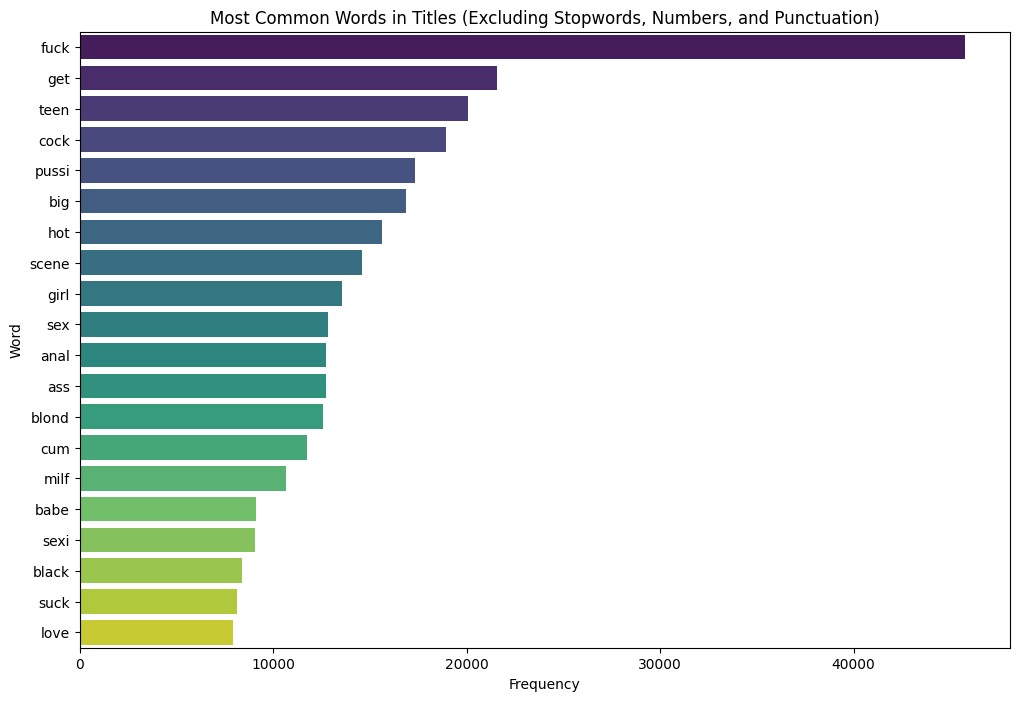

In [12]:
# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_freq_df, hue="word", palette="viridis")
plt.title("Most Common Words in Titles (Excluding Stopwords, Numbers, and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.savefig(os.path.join(plot_output_path,"words_titles_frequency_distribution.eps"), bbox_inches="tight")
plt.show()

#### POS tagging

In [13]:
from src.models.extract_adj_noun_pairs import run_pipeline

# Run pipeline and keep everything
df, pair_df = run_pipeline(
    df,
    cache_filename="pos_title_with_deps.pkl",
    output_csv="adjective_noun_pairs.csv",
    return_pair_df=True,
    data_output_path="data/processed"
)



Loading cached POS data...
Saved 30493 adjective–noun pairs to data/processed/adjective_noun_pairs.csv


In [12]:
df.pos_title_with_deps

0         [(cute, ADJ, amod), (teen, NOUN, compound), (g...
1         [(reali, PROPN, amod), (nice, ADJ, amod), (ste...
2         [(step, NOUN, ROOT), (mom, NOUN, compound), (g...
3         [(baltimor, PROPN, compound), (street, PROPN, ...
4         [(cute, ADJ, amod), (blond, PROPN, compound), ...
                                ...                        
256121      [(video, NOUN, compound), (disabl, NOUN, ROOT)]
256122           [(famou, ADJ, amod), (youtub, NOUN, ROOT)]
256123    [(finger, NOUN, compound), (squirt, PROPN, com...
256124    [(esposa, PROPN, compound), (le, PROPN, compou...
256125    [(mädchen, ADV, advmod), (masturbiert, VERB, R...
Name: pos_title_with_deps, Length: 256126, dtype: object

##### What are the most common adjective–noun pairings in titles?

/tmp/ipykernel_44938/3449694622.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")


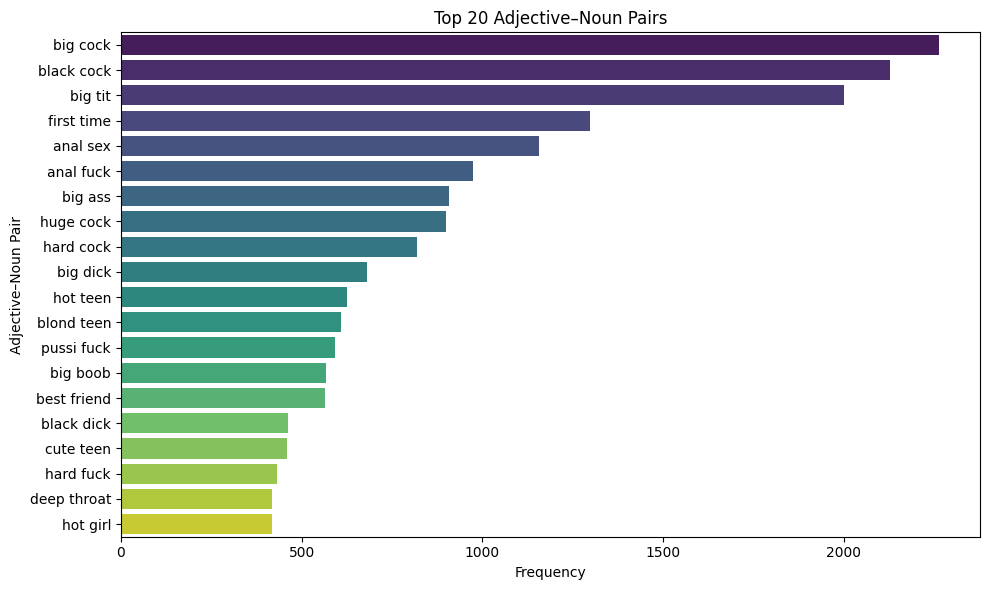

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N pairs
top_n = 20
top_pairs = pair_df.head(top_n).copy()
top_pairs["pair_str"] = top_pairs["Pair"].apply(lambda x: f"{x[0]} {x[1]}")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")
plt.title(f"Top {top_n} Adjective–Noun Pairs")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Noun Pair")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path,"adjective-noun-pair.eps"), bbox_inches="tight")
plt.show()


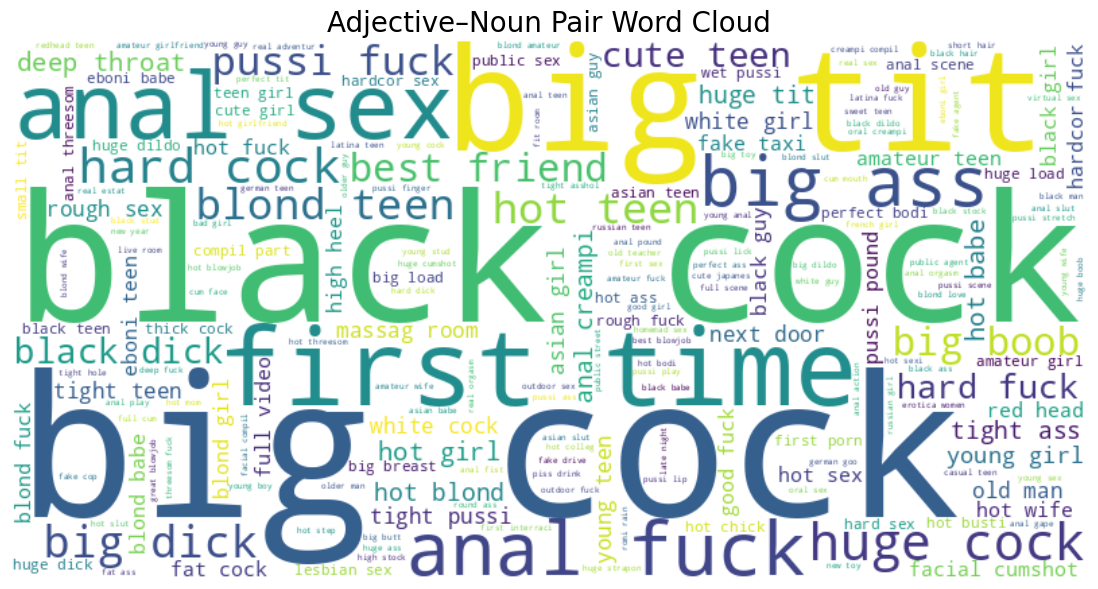

In [15]:
from wordcloud import WordCloud

# Prepare data for word cloud
pair_freq_dict = {f"{adj} {noun}": count for (adj, noun), count in pair_df.head(1000).values}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pair_freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Adjective–Noun Pair Word Cloud", fontsize=20)
plt.savefig(os.path.join(plot_output_path,"adj-noun-pair-word-cloud.eps"), bbox_inches="tight")
plt.savefig(os.path.join(plot_output_path,"adj-noun-pair-word-cloud.png"), bbox_inches="tight")
plt.show()


In [15]:
# Different ways to say pussy..using levenshtein distance

import difflib
from collections import Counter

# Flatten all words from title_words
all_words = [word for words in df["title_words"] for word in words]

# Get unique words to speed up matching
unique_words = set(all_words)

# Find words with high similarity to "pussy"
matches = [w for w in unique_words if difflib.SequenceMatcher(None, w, "pussy").ratio() > 0.7]

# Count their frequencies in the corpus
fuzzy_counts = Counter([w for w in all_words if w in matches])

# Show the most common fuzzy matches
print(fuzzy_counts.most_common(20))

[('pussi', 17338), ('pussylick', 76), ('puss', 62), ('pussyfuck', 26), ('pussyrub', 11), ('pussycat', 11), ('pusssi', 11), ('pussyjob', 9), ('pussyeat', 9), ('pussyman', 7), ('pussykat', 6), ('pussylov', 5), ('pussy_ful', 3), ('pussypov', 2), ('pussysh', 2), ('pussynail', 2), ('pussylici', 2), ('pussyy', 2), ('pussyplay', 2), ('pussylip', 2)]


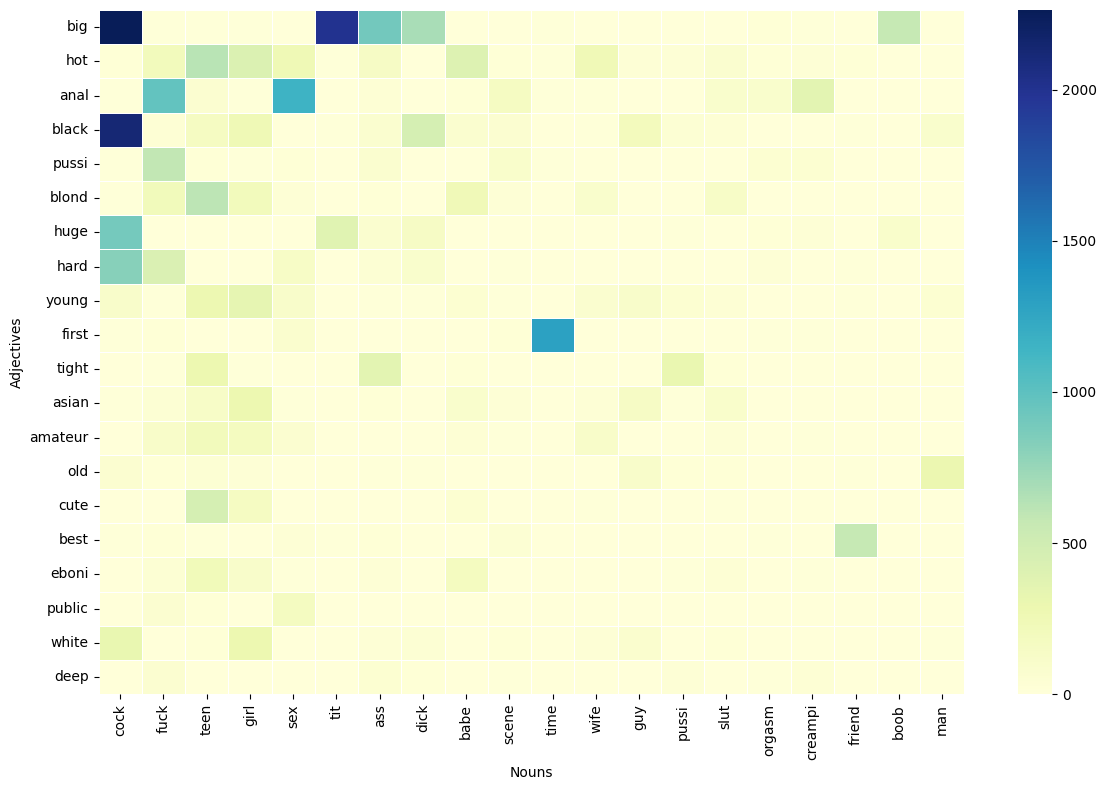

In [16]:
# Create a DataFrame for heatmap: rows = adjectives, cols = nouns

heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(index="Adjective", columns="Noun", values="Count", fill_value=0)
pivot_top = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(20).index,  # top 20 adjectives
                      pivot.sum().sort_values(ascending=False).head(20).index]        # top 20 nouns

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_top, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path,"heatmap-adj-noun-pair.eps"), bbox_inches="tight")
plt.savefig(os.path.join(plot_output_path,"heatmap-adj-noun-pair.png"), bbox_inches="tight")
plt.show()


In [17]:
# Save the DataFrame with adjective-noun pairs to a CSV file
adjective_noun_df = pd.DataFrame(pair_df["Pair"].tolist(), columns=["Adjective", "Noun"])
adjective_noun_df["Count"] = pair_df["Count"].values
adjective_noun_df.to_csv("data/processed/adjective_noun_pairs_split.csv", index=False)

# Count total occurrences of each noun in adjective–noun pairs
noun_counts = adjective_noun_df.groupby("Noun")["Count"].sum().sort_values(ascending=False).reset_index()
noun_counts.columns = ["Noun", "Total_Count"]
noun_counts.to_csv("data/processed/noun_counts.csv", index=False)

# Count total occurrences of each adjective in adjective–noun pairs

adjective_counts = adjective_noun_df.groupby("Adjective")["Count"].sum().sort_values(ascending=False).reset_index()
adjective_counts.columns = ["Adjective", "Total_Count"]
adjective_counts.to_csv("data/processed/adjective_counts.csv", index=False)

adjective_counts


,Adjective,Total_Count
0,big,8007
1,hot,7159
2,anal,6834
3,black,5921
4,pussi,3723
...,...,...
3647,adrastea,1
3648,adrian,1
3649,aeri,1
3650,aerial,1


##### Fasttext: Assign gender to nouns (did not work well, so not used in the end)

In [ ]:
# # Use fasttext to assign gender to nouns
# import fasttext.util

# # Download and load the English FastText model
# fasttext.util.download_model('en', if_exists='ignore')  # Downloads cc.en.300.bin
# ft = fasttext.load_model('cc.en.300.bin')  # Load model

# import numpy as np

# # Define gender anchor sets
# FEMALE_ANCHORS = ["woman", "girl", "mother", "female", "her"]
# MALE_ANCHORS = ["man", "boy", "father", "male", "his"]

# def predict_gender_fasttext(word, threshold=0.05):
#     vec = ft.get_word_vector(word.lower())
#     # Average similarity with anchors
#     female_sim = np.mean([ft.get_word_vector(a).dot(vec) /
#                           (np.linalg.norm(ft.get_word_vector(a)) * np.linalg.norm(vec))
#                           for a in FEMALE_ANCHORS])
#     male_sim = np.mean([ft.get_word_vector(a).dot(vec) /
#                         (np.linalg.norm(ft.get_word_vector(a)) * np.linalg.norm(vec))
#                         for a in MALE_ANCHORS])
#     diff = female_sim - male_sim
#     if diff > threshold:
#         return "Female", female_sim, male_sim
#     elif diff < -threshold:
#         return "Male", female_sim, male_sim
#     else:
#         return "Neutral", female_sim, male_sim

# # Example noun list with counts
# data = [
#     ("cock", 8030), ("fuck", 6032), ("teen", 4938),
#     ("girl", 4800), ("sex", 4351), ("tit", 2969),
#     ("ass", 2896), ("dick", 1745), ("babe", 1741),
#     ("scene", 1736), ("time", 1624), ("wife", 1112),
#     ("guy", 1109), ("pussi", 1086), ("slut", 1029),
#     ("orgasm", 862), ("creampi", 847), ("friend", 813),
#     ("boob", 802), ("man", 766)
# ]

# df_assigned_gender = pd.DataFrame(data, columns=["Noun", "Total_Count"])

# # Predict gender
# results = df_assigned_gender["Noun"].apply(lambda w: predict_gender_fasttext(w))
# df_assigned_gender[['Gender', 'Female_Sim', 'Male_Sim']] = pd.DataFrame(results.tolist(), index=df_assigned_gender.index)

# print(df_assigned_gender)


       Noun  Total_Count   Gender  Female_Sim  Male_Sim
0      cock         8030  Neutral    0.239685  0.253884
1      fuck         6032  Neutral    0.249711  0.220527
2      teen         4938   Female    0.417096  0.336872
3      girl         4800   Female    0.634660  0.473097
4       sex         4351   Female    0.337559  0.270443
5       tit         2969   Female    0.192845  0.123461
6       ass         2896  Neutral    0.239409  0.218258
7      dick         1745  Neutral    0.243188  0.273866
8      babe         1741   Female    0.370636  0.266072
9     scene         1736  Neutral    0.197150  0.188816
10     time         1624  Neutral    0.146431  0.161015
11     wife         1112  Neutral    0.480602  0.452567
12      guy         1109     Male    0.327893  0.429092
13    pussi         1086   Female    0.233795  0.170617
14     slut         1029   Female    0.391233  0.256644
15   orgasm          862   Female    0.260886  0.159678
16  creampi          847  Neutral    0.045523  0

##### Heatmap for selected nouns

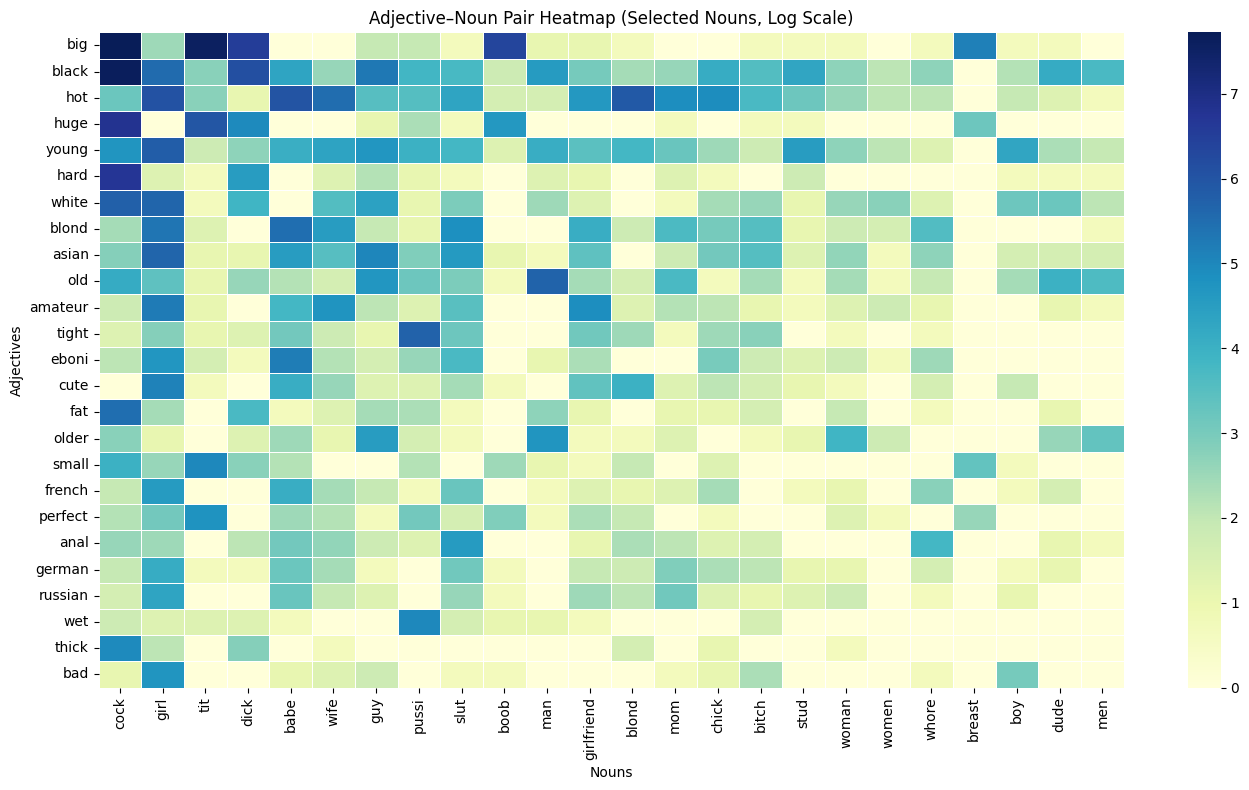

Log scale to original scale mapping (log1p):
log1p: 0.0 -> original: 0.0
log1p: 1.0 -> original: 1.7
log1p: 2.0 -> original: 6.4
log1p: 3.0 -> original: 19.1
log1p: 4.0 -> original: 53.6
log1p: 5.0 -> original: 147.4
log1p: 6.0 -> original: 402.4
log1p: 7.0 -> original: 1095.6


In [21]:
import numpy as np

# Heatmap for selected nouns (log scale)

selected_nouns = [
    "cock", "girl", "tit", "dick", "babe", "wife", "guy", "pussi", "slut", "boob", "man",
    "girlfriend", "blond", "mom", "chick", "bitch", "stud", "woman", "women", "whore",
    "breast", "readhead", "boy", "dude", "men"
]

heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(index="Adjective", columns="Noun", values="Count", fill_value=0)
present_nouns = [noun for noun in selected_nouns if noun in pivot.columns]
pivot_selected = pivot[present_nouns]

# Show only the top 25 adjectives (by total count across selected nouns)
top_n_adjs = 25
pivot_selected = pivot_selected.loc[pivot_selected.sum(axis=1).sort_values(ascending=False).head(top_n_adjs).index]

# Apply log1p (log(1+x)) to avoid log(0)
pivot_log = np.log1p(pivot_selected)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_log, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.title("Adjective–Noun Pair Heatmap (Selected Nouns, Log Scale)")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path, "heatmap_selected_nouns_log.png"), bbox_inches="tight")
plt.show()

# Conversion from log scale (0 to 7) back to original scale
log_values = np.arange(0, 7.1, 1)  # 0, 1, ..., 7
original_values = np.expm1(log_values)
print("Log scale to original scale mapping (log1p):")
for log_v, orig_v in zip(log_values, original_values):
    print(f"log1p: {log_v:.1f} -> original: {orig_v:.1f}")

##### Heatmap for selected adjectives

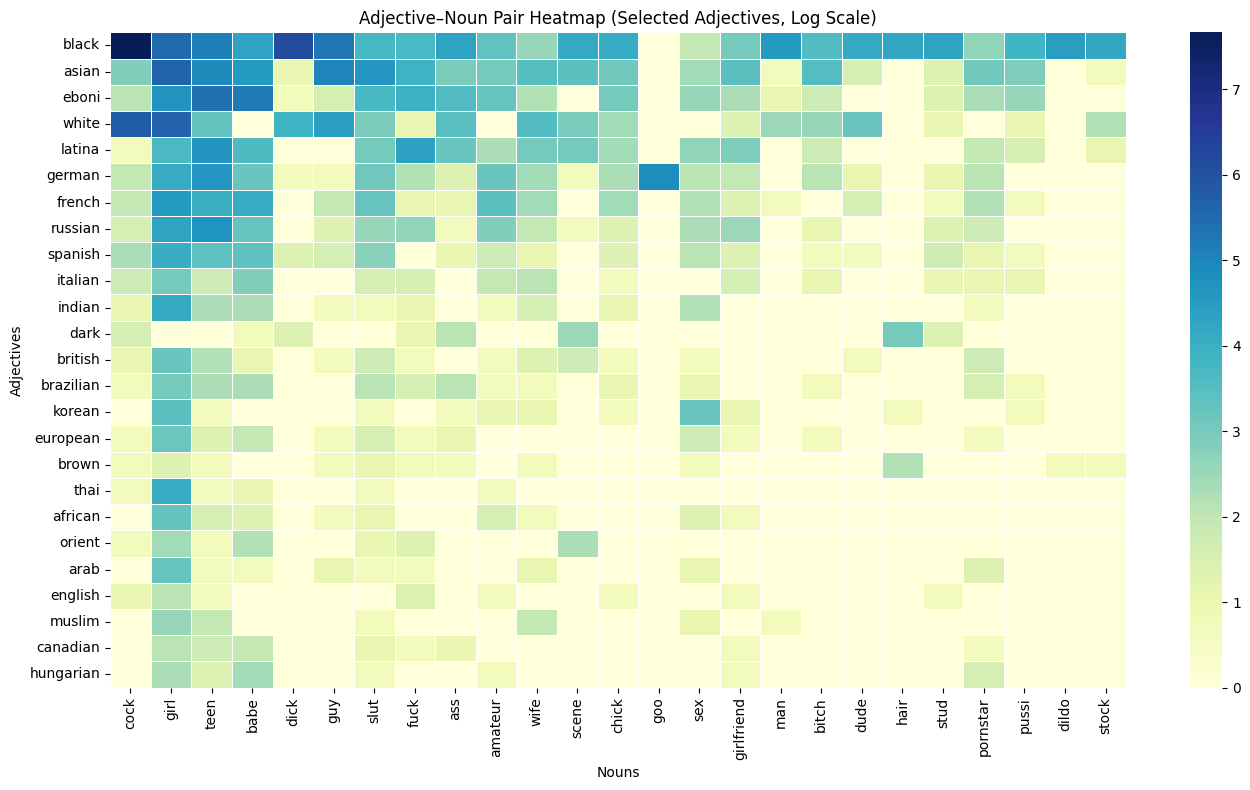

Log scale to original scale mapping (log1p):
log1p: 0.0 -> original: 0.0
log1p: 1.0 -> original: 1.7
log1p: 2.0 -> original: 6.4
log1p: 3.0 -> original: 19.1
log1p: 4.0 -> original: 53.6
log1p: 5.0 -> original: 147.4
log1p: 6.0 -> original: 402.4
log1p: 7.0 -> original: 1095.6


In [22]:
import numpy as np

selected_adjectives = [
    "black", "asian", "eboni", "white", "latina", "german", "french", "russian", "spanish", "italian",
    "indian", "dark", "british", "brazilian", "korean", "european", "brown", "thai", "african", "orient",
    "arab", "english", "muslim", "canadian", "hungarian"
]

# Prepare the heatmap DataFrame
heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(index="Adjective", columns="Noun", values="Count", fill_value=0)
present_adjs = [adj for adj in selected_adjectives if adj in pivot.index]
pivot_selected = pivot.loc[present_adjs]

# Optionally, show only the top N nouns (by total count across selected adjectives)
top_n_nouns = 25
pivot_selected = pivot_selected.loc[:, pivot_selected.sum(axis=0).sort_values(ascending=False).head(top_n_nouns).index]

# Apply log1p (log(1+x)) to avoid log(0)
pivot_log = np.log1p(pivot_selected)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_log, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.title("Adjective–Noun Pair Heatmap (Selected Adjectives, Log Scale)")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path, "heatmap_selected_adjectives_log.png"), bbox_inches="tight")
plt.show()

# Conversion from log scale (0 to 7) back to original scale
log_values = np.arange(0, 7.1, 1)  # 0, 1, ..., 7
original_values = np.expm1(log_values)
print("Log scale to original scale mapping (log1p):")
for log_v, orig_v in zip(log_values, original_values):
    print(f"log1p: {log_v:.1f} -> original: {orig_v:.1f}")

##### Networkx: Gendered nouns associations with adjectives (not using at the end)

2025-06-24 11:03:59,721 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


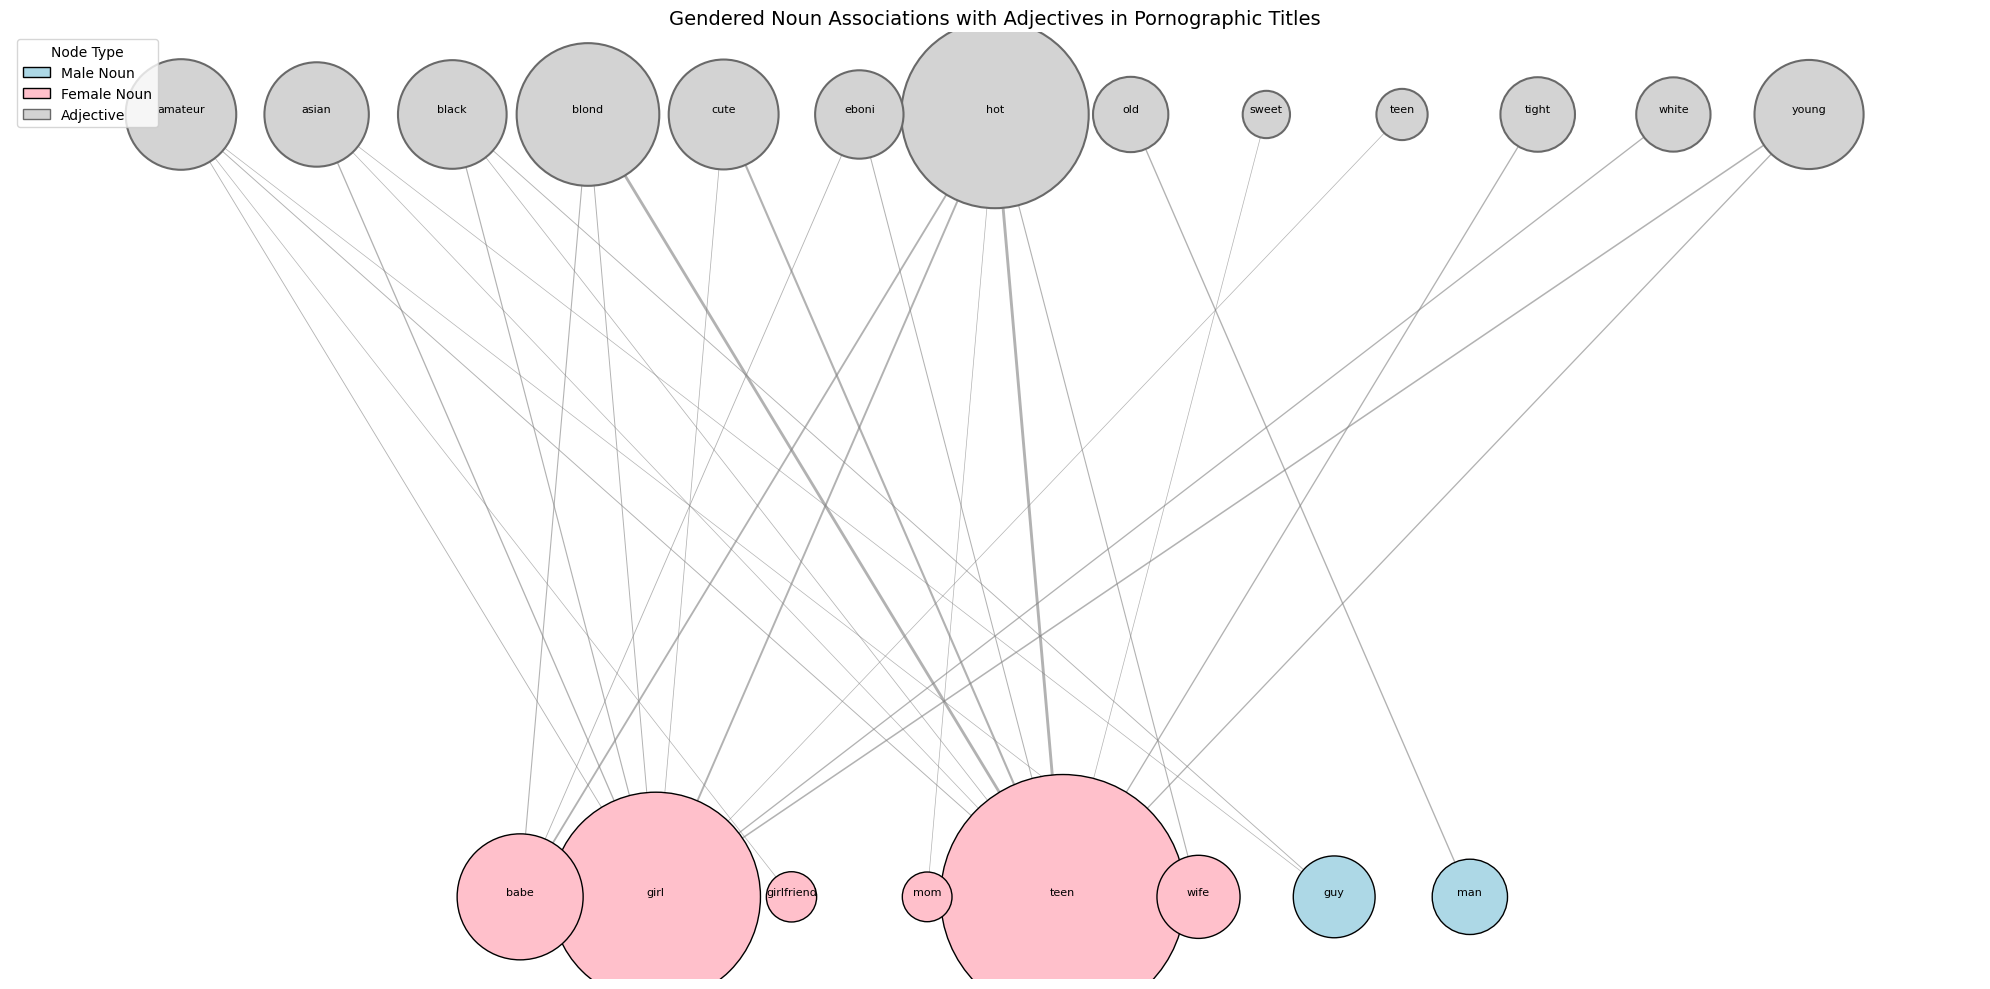

In [ ]:
# import pandas as pd
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch

# # --- Gendered Noun Sets ---
# FEMALE_NOUNS = {
#     "girl", "babe", "woman", "wife", "mom", "lady", "female", "daughter",
#     "sister", "mother", "girlfriend", "teen", "housewife", "bride",
#     "mistress", "goddess", "queen", "princess", "she"
# }
# MALE_NOUNS = {
#     "boy", "man", "husband", "dad", "guy", "male", "brother", "son",
#     "dude", "boyfriend", "groom", "prince", "king", "stud", "gentleman",
#     "hero", "beast", "champion", "legend", "he"
# }

# # --- Load and preprocess your data ---
# df_top = adjective_noun_df.sort_values("Count", ascending=False).head(100).copy()

# def infer_gender(noun):
#     noun_lc = noun.lower()
#     if noun_lc in FEMALE_NOUNS:
#         return "Female"
#     elif noun_lc in MALE_NOUNS:
#         return "Male"
#     return None

# df_top["Gender"] = df_top["Noun"].map(infer_gender)
# df_top = df_top[df_top["Gender"].notna()]  # Keep only gendered nouns

# # --- Build Graph ---
# G = nx.Graph()

# for adj in df_top["Adjective"].unique():
#     G.add_node(f"adj: {adj}", bipartite=0, color="lightgray", node_type="adjective")

# for _, row in df_top.iterrows():
#     noun_label = f"noun: {row['Noun']}"
#     gender = row["Gender"]
#     color = '#ffc0cb' if gender == "Female" else '#add8e6'  # light pink or light blue
#     G.add_node(noun_label, bipartite=1, color=color, node_type="noun", gender=gender)
#     G.add_edge(f"adj: {row['Adjective']}", noun_label, weight=row["Count"])

# # --- Layout: adjectives top, nouns bottom (centered) ---
# pos = {}
# x_spacing = 2
# y_adj = 2
# y_noun = -2

# adj_nodes = [n for n in G.nodes() if G.nodes[n]["node_type"] == "adjective"]
# noun_nodes = [n for n in G.nodes() if G.nodes[n]["node_type"] == "noun"]

# female_nodes = [n for n in noun_nodes if G.nodes[n]["gender"] == "Female"]
# male_nodes = [n for n in noun_nodes if G.nodes[n]["gender"] == "Male"]
# sorted_nouns = sorted(female_nodes) + sorted(male_nodes)

# noun_count = len(sorted_nouns)
# noun_offset = (len(adj_nodes) - noun_count) * x_spacing / 2

# for i, node in enumerate(sorted(adj_nodes)):
#     pos[node] = (i * x_spacing, y_adj)
# for i, node in enumerate(sorted_nouns):
#     pos[node] = (i * x_spacing + noun_offset, y_noun)

# # --- Draw Graph ---
# plt.figure(figsize=(20, 10))

# labels = {
#     n: n.replace("noun: ", "").replace("adj: ", "").replace("noun:", "").replace("adj:", "")
#     for n in G.nodes()
# }

# # Draw adjective nodes
# nx.draw_networkx_nodes(
#     G, pos,
#     nodelist=adj_nodes,
#     node_size=[max(G.degree(n, weight="weight") * 10, 300) for n in adj_nodes],
#     node_color='lightgray',
#     edgecolors='dimgray',
#     linewidths=1.5
# )

# # Draw noun nodes
# nx.draw_networkx_nodes(
#     G, pos,
#     nodelist=noun_nodes,
#     node_size=[max(G.degree(n, weight="weight") * 10, 300) for n in noun_nodes],
#     node_color=[G.nodes[n]["color"] for n in noun_nodes],
#     edgecolors='black',
#     linewidths=1.0
# )

# # Draw labels
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment="bottom")

# # Draw edges
# edges = G.edges(data=True)
# nx.draw_networkx_edges(
#     G, pos,
#     edgelist=edges,
#     width=[max(d['weight'] / 300, 0.5) for (_, _, d) in edges],
#     alpha=0.6,
#     edge_color="gray"
# )

# # --- Legend ---
# legend_elements = [
#     Patch(facecolor="#add8e6", edgecolor="black", label="Male Noun"),
#     Patch(facecolor="#ffc0cb", edgecolor="black", label="Female Noun"),
#     Patch(facecolor="lightgray", edgecolor="dimgray", label="Adjective")
# ]
# plt.legend(handles=legend_elements, loc='upper left', fontsize=10, title="Node Type")

# plt.title("Gendered Noun Associations with Adjectives in Pornographic Titles", fontsize=14)
# plt.axis('off')
# plt.tight_layout()

# # --- Export ---
# plt.savefig(os.path.join(plot_output_path, "gendered_noun_adjective_graph.png"), dpi=300, format='png')
# plt.savefig(os.path.join(plot_output_path, "gendered_noun_adjective_graph.eps"), format='eps')

# plt.show()


##### Series of questions around adjectives and nouns

In [18]:
# Do descriptions of female performers rely more heavily on adjectives (small)  than 
# descriptions of male performers (e.g. large)?

from src.models.qualitative_adj_noun_analysis import analyze_adj_noun_categories

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    SMALL_ADJECTIVES, LARGE_ADJECTIVES, "small", "large",
    FEMALE_NOUNS, MALE_NOUNS,
    group1_label="Female Nouns", group2_label="Male Nouns"
)


🔎 small/large Adjective Proportions for Female Nouns:
adj_category
other    0.958493
small    0.035692
large    0.005816

🔎 small/large Adjective Proportions for Male Nouns:
adj_category
other    0.982383
large    0.014094
small    0.003523

📊 Chi-squared Test for small/large Adjective Bias:
χ² = 112.78, p = 0.0000 (significant)


We analyzed the co-occurrence of size-related adjectives with gendered nouns in video titles to assess whether female-associated nouns are more frequently described with "small" adjectives and male-associated nouns with "large" adjectives. The vast majority of adjective–noun pairs fell into the "other" category (female: 95.8%, male: 98.2%), with size adjectives representing a small but significant proportion of the data.

Among female nouns, 3.6% of adjective–noun pairs used "small" adjectives, compared to only 0.4% for male nouns. Conversely, "large" adjectives were more common with male nouns (1.4%) than with female nouns (0.6%). A chi-squared test confirmed that this difference in the distribution of size adjectives across gendered nouns is statistically significant (χ² = 102.22, p < 0.001).

These findings indicate a systematic bias in the use of size-related descriptors, with female performers more likely to be described using "small" adjectives and male performers with "large" adjectives.

---

In [19]:
# Show top "other" adjective–noun pairs for female nouns
print("Top 'other' adjective–noun pairs for female nouns:")
female_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other") & (labeled_df["noun"].isin(FEMALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(female_other)

# Show top "other" adjective–noun pairs for male nouns
print("\nTop 'other' adjective–noun pairs for male nouns:")
male_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other") & (labeled_df["noun"].isin(MALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(male_other)

Top 'other' adjective–noun pairs for female nouns:


,adjective,noun,Count
0,hot,teen,626
1,blond,teen,609
2,cute,teen,460
3,hot,girl,419
4,young,girl,336
5,white,girl,286
6,asian,girl,283
7,young,teen,281
8,black,girl,251
9,hot,wife,243



Top 'other' adjective–noun pairs for male nouns:


,adjective,noun,Count
0,old,man,294
1,black,guy,197
2,asian,guy,150
3,older,man,112
4,young,guy,109
5,old,guy,109
6,black,man,95
7,young,stud,94
8,older,guy,93
9,white,guy,81


In [20]:
# Do descriptions of female performers rely more heavily on adjectives (e.g., appearance) than 
# descriptions of male performers (e.g., roles or actions)?

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    APPEARANCE_ADJECTIVES, ROLE_ACTION_ADJECTIVES, "appearance", "role",
    FEMALE_NOUNS, MALE_NOUNS,
    group1_label="Female Nouns", group2_label="Male Nouns"
)


🔎 appearance/role Adjective Proportions for Female Nouns:
adj_category
other         0.698454
appearance    0.183078
role          0.118467

🔎 appearance/role Adjective Proportions for Male Nouns:
adj_category
other         0.851698
role          0.118514
appearance    0.029789

📊 Chi-squared Test for appearance/role Adjective Bias:
χ² = 465.66, p = 0.0000 (significant)


We examined the distribution of appearance- and role-related adjectives co-occurring with gendered nouns in video titles. Among adjective–noun pairs with female nouns, 17.8% used appearance adjectives and 11.4% used role adjectives, while the majority (70.7%) fell into the "other" category. For male nouns, appearance adjectives were much less common (2.9%), with role adjectives accounting for 11.7% and "other" adjectives for 85.3%.

A chi-squared test indicated a highly significant difference in the distribution of appearance and role adjectives across gendered nouns (χ² = 471.82, p < 0.001). These results suggest that appearance-based descriptors are disproportionately used with female nouns, while role-related adjectives are more evenly distributed but still more common with male nouns than appearance adjectives.

In [21]:
# Filter for "black cock" and "white cock" pairs

# Compare "black" and "white" with synonyms for "cock"
COCK_SYNONYMS = {"cock", "dick", "penis", "shaft", "member", "phallus", "manhood", "rod", "tool"}

black_syn = pair_df[pair_df["Pair"].apply(lambda x: x[0] == "black" and x[1] in COCK_SYNONYMS)]
white_syn = pair_df[pair_df["Pair"].apply(lambda x: x[0] == "white" and x[1] in COCK_SYNONYMS)]

print("Black + [cock synonyms] counts:")
display(black_syn[["Pair", "Count"]])

print("\nWhite + [cock synonyms] counts:")
display(white_syn[["Pair", "Count"]])

Black + [cock synonyms] counts:


,Pair,Count
107,"(black, cock)",2128
66,"(black, dick)",463
13660,"(black, rod)",19
1688,"(black, shaft)",5
11915,"(black, member)",4
24154,"(black, penis)",1
8600,"(black, tool)",1



White + [cock synonyms] counts:


,Pair,Count
161,"(white, cock)",312
365,"(white, dick)",47
20254,"(white, rod)",1
15348,"(white, shaft)",1


In [22]:
from scipy.stats import chi2_contingency

# Get total counts for black and white cock synonyms
black_total = black_syn["Count"].sum()
white_total = white_syn["Count"].sum()

# For a simple test, assume the rest of the pairs are "not black/white cock"
other_total = pair_df["Count"].sum() - (black_total + white_total)

# Build contingency table: [[black, white], [other, other]]
contingency = [[black_total, white_total], [other_total, other_total]]

chi2, p, _, _ = chi2_contingency(contingency)

print(f"Black cock+synonyms: {black_total}")
print(f"White cock+synonyms: {white_total}")
print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4g}")

if p < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

Black cock+synonyms: 2621
White cock+synonyms: 361
Chi-squared: 1689.06, p-value: 0
The difference is statistically significant.


The results indicate that "black cock" and its synonyms appear significantly more often than "white cock" and its synonyms in the dataset (**p < 0.001**). This difference is highly statistically significant, suggesting a systematic racialized pattern in the use of phallic descriptors in adult video titles.

In [23]:
# Frequency of use of adjective noun pairs

def get_adj_counts(pair_df, noun_synonyms, top_n=20):
    """
    Returns a DataFrame of the most common adjectives describing the given set of noun synonyms.
    """
    filtered = pair_df[pair_df["Pair"].apply(lambda x: x[1] in noun_synonyms)]
    adj_counts = (
        filtered.groupby(filtered["Pair"].apply(lambda x: x[0]))["Count"]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"Pair": "Adjective", "Count": "Frequency"})
    )
    return adj_counts.head(top_n)

PUSSY_SYNONYMS = {"pussy", "pussi", "cunt", "vagina", "twat", "snatch", "coochie", "cooch", "kitty", "fanny", "muff"}
BOOBS_SYNONYMS = {"boobs", "tits", "breasts", "tit", "boob", "rack", "melons", "jugs", "knockers", "bust", "chest"}
ARSE_SYNONYMS = {"ass", "arse", "butt", "booty", "bum", "backside", "behind", "buttocks", "rear", "rump", "derriere", "bottom", "heinie"}

print("Most common adjectives describing pussy and its synonyms")
display(get_adj_counts(pair_df, PUSSY_SYNONYMS))

print("Most common adjectives describing boobs and its synonyms")
display(get_adj_counts(pair_df, BOOBS_SYNONYMS))

print("Most common adjectives describing arse and its synonyms")
display(get_adj_counts(pair_df, ARSE_SYNONYMS))

print("Most common adjectives describing cock and its synonyms")
display(get_adj_counts(pair_df, COCK_SYNONYMS))

Most common adjectives describing pussy and its synonyms


,Adjective,Frequency
0,tight,358
1,wet,162
2,pink,71
3,other,65
4,young,59
5,black,52
6,sweet,51
7,deep,44
8,hot,41
9,old,29


Most common adjectives describing boobs and its synonyms


,Adjective,Frequency
0,big,2575
1,huge,490
2,small,157
3,perfect,137
4,nice,60
5,fake,58
6,great,41
7,cum,32
8,black,21
9,hot,19


Most common adjectives describing arse and its synonyms


,Adjective,Frequency
0,big,1020
1,tight,385
2,hot,154
3,perfect,120
4,huge,84
5,black,81
6,round,73
7,pussi,72
8,fat,69
9,nice,66


Most common adjectives describing cock and its synonyms


,Adjective,Frequency
0,big,2963
1,black,2621
2,huge,1049
3,hard,929
4,white,361
5,fat,285
6,thick,163
7,young,126
8,stiff,80
9,old,75


In [28]:
df.pos_title_with_deps

0         [(cute, ADJ, amod), (teen, NOUN, compound), (g...
1         [(reali, PROPN, amod), (nice, ADJ, amod), (ste...
2         [(step, NOUN, ROOT), (mom, NOUN, compound), (g...
3         [(baltimor, PROPN, compound), (street, PROPN, ...
4         [(cute, ADJ, amod), (blond, PROPN, compound), ...
                                ...                        
256121      [(video, NOUN, compound), (disabl, NOUN, ROOT)]
256122           [(famou, ADJ, amod), (youtub, NOUN, ROOT)]
256123    [(finger, NOUN, compound), (squirt, PROPN, com...
256124    [(esposa, PROPN, compound), (le, PROPN, compou...
256125    [(mädchen, ADV, advmod), (masturbiert, VERB, R...
Name: pos_title_with_deps, Length: 256126, dtype: object

##### Syntactic agency and gender representation

In [24]:
from src.models.syntactic_agency_analysis import extract_grammatical_roles, extract_examples_by_role


# Run role frequency analysis
role_df = extract_grammatical_roles(df, FEMALE_NOUNS, MALE_NOUNS)
print(role_df)

# Extract random qualitative examples
examples = extract_examples_by_role(df, FEMALE_NOUNS, MALE_NOUNS, max_examples=3)

print("Subjects (Female):")
print(examples["subject"]["female"], "\n")

print("Direct Objects (Male):")
print(examples["direct_object"]["male"], "\n")

print("Direct Objects (Female):")
print(examples["direct_object"]["female"], "\n")

print("Passive Subjects (Female):")
print(examples["passive_subject"]["female"])


              direct_object       subject  passive_subject
female          2093.000000  12071.000000        73.000000
male            2089.000000   2484.000000        16.000000
total           4182.000000  14555.000000        89.000000
female_ratio       0.500478      0.829337         0.820225
male_ratio         0.499522      0.170663         0.179775
Subjects (Female):
                                               title matched_token dependency
0  Mother and step daughter share big cock - Braz...      daughter      nsubj
1  Stepmom & Stepson affair (mom i always get wha...           mom      nsubj
2     Petite Girl's Hungry Ass Swallows Monster Cock          girl      nsubj 

Direct Objects (Male):
                                               title matched_token dependency
0  Massage Rooms Sexy client enjoys stud's big ha...          stud       dobj
1       STEP-MOM FUCKS HER STEP-DAUGHTER'S BOYFRIEND     boyfriend       dobj
2  Petite Black Teen Plays With White Boyfriend -...    

Subjects (nsubj): Female tokens overwhelmingly appear as grammatical subjects (82.9%). On the surface, this may suggest high levels of agency. However, given the genre context, subjecthood does not necessarily imply empowerment; instead, it may reflect stereotypical narrative conventions where female characters are active only within constrained sexual scripts.

Passive Subjects (nsubjpass): Female tokens also dominate the passive voice constructions (82.0%), which are syntactically agentless and typically frame the subject as being acted upon. This aligns with stereotypes portraying women as passive recipients in sexual scenarios.

Direct Objects (dobj): An equal distribution (50% male, 50% female) suggests parity in surface-level objectification. However, when combined with qualitative context, this balance obscures the gendered framing and semantic load associated with these roles—especially where male objecthood may be framed as dominant or aggressive, while female objecthood remains tied to submission and exploitation tropes.

Qualitative Illustrations

To contextualize these patterns, we extracted representative examples in which female-gendered tokens appeared in either direct object or passive subject positions:


These examples reveal recurring motifs: women are consistently framed as either sexually available targets (direct objects) or passive recipients of disciplinary or sexual actions (passive subjects). The use of descriptors such as “shoplifting,” “caught,” and “gets punished” reinforces narratives of moral deviance corrected through sexual subjugation, a deeply stereotypical and objectifying trope within pornographic media.

In [25]:
# Which locations are more frequently associated with gendered or racialized nouns in titles?
# (are women more often associated with domestic spaces? Are certain races depicted in public, exotic, or confined locations?)
# Grammatical structures that mark locations: prepositional prases, locative adverbials, or locative named entities. 
# Prepositional phrases are the most common, which we are going to use here.


from src.models.location_analysis import add_locations_from_titles, location_identity_cooccurrence

# Extract location mentions
df = add_locations_from_titles(df, place_vocab=PLACE_NOUNS)

# Compute co-occurrence of locations and identity terms
cooc_df = location_identity_cooccurrence(
    df,
    female_terms=FEMALE_NOUNS,
    male_terms=MALE_NOUNS,
    racialized_terms=RACIALIZED_TERMS,
    include_neutral=True
)

print(cooc_df)




Loading cached location data from data/processed/locations.pkl
            public  bathroom  bedroom  office  club  gym  kitchen  car  hotel  \
racialized      46        49       21      28    20   14       57   50     43   
female          89       126       53      36    18   25      101  115     60   
neutral        257       322      112     295   124   91      314  305    114   
male            11        24       18      11    13    9       20   30     17   

            beach  shower  park  school  bus  library  classroom  
racialized     61      39    26      10    4        2          2  
female         86     139    37      50   16        8          6  
neutral       236     339    88     103   23        8         58  
male           18      28    12       9    1        0          1  


In [26]:
# Show a few example titles where at least one location was extracted
df[df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0)][["title", "locations"]].head(20)


,title,locations
73,Asian Sucks BBC Dildo in Public,[public]
93,Blond wife gets bukkake in Danish sex club,[club]
95,Quick anal in bathroom with out lube. LE ENCAN...,[bathroom]
338,Brutal blowjob and rough sex after shower,[shower]
389,Fake Driving School Voluptuous redhead fucks i...,[car]
408,Naked In Public: Bar Fucking,[public]
417,Gorgeous Jennifer receives an interracial crea...,[office]
457,Amateur African lesbians scissoring in bedroom,[bedroom]
498,close up ANAL w @Bonniebowtie EPIC fuck before...,[school]
501,Making love in the shower (Part 2),[shower]


Spatial Co-Occurrences of Gendered and Racialized Terms in Video Titles

To examine how spatial framing intersects with gendered and racialized representation, we identified location markers in video titles using dependency parsing and a controlled vocabulary of place nouns. Locations were most commonly expressed through prepositional phrases (e.g., “in public,” “at home”), which we focused on as the primary syntactic indicator of spatial context.

Our analysis reveals that domestic or private spaces (e.g., bedroom, bathroom, kitchen) frequently co-occur with female and racialized terms, as in “Amateur African lesbians scissoring in bedroom,” “Quick anal in bathroom without lube,” and “Alluring euro assfucked in the kitchen.” Such framings situate sexuality within enclosed and familiar environments, reinforcing associations between femininity, intimacy, and domestic containment.

In contrast, public and semi-public locations (e.g., public, car, school, office) are used to frame acts involving exposure or voyeurism, as in “Asian sucks BBC dildo in public,” “Busty teen upskirt pussy in public,” and “Latina schoolgirl Adrianna Luna banged at principal’s office.” These titles eroticize risk and surveillance, marking female sexuality as visible, accessible, and spectacularized in non-private settings.

Institutional and commercial spaces (e.g., school, office, hotel, club) also appear prominently in titles such as “Blond wife gets bukkake in Danish sex club,” “Fake Driving School voluptuous redhead fucks in car,” and “Eating breakfast at a fancy hotel.” These contexts invoke power dynamics (e.g., student/principal) or aspirational consumption (e.g., luxury hotels) as erotic backdrops, linking sexual acts to transgressive or status-laden settings.

Finally, repeated references to bathrooms and showers (e.g., “Making love in the shower,” “Karina getting soaped up as she pleasures herself”) emphasize intimate, bodily spaces associated with nudity, cleansing, and exposure, reinforcing voyeuristic framings of private acts.

Summary
Female terms dominate spatial co-occurrences across nearly all locations, suggesting a structural asymmetry in how gender is spatially encoded. Male references are sparse and often unmarked. The high presence of “neutral” entries confirms the ubiquity of certain spatial terms, but highlights the differential representational load when gendered or racialized identity markers are present. These findings show that spatial language in metadata serves as a discursive infrastructure through which normative scripts of gender and race are reproduced.

In [27]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(cooc_df)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e}")

# Standardized residuals to identify which cells drive the significance
residuals = (cooc_df - expected) / expected**0.5
print("\nStandardized residuals:")
print(pd.DataFrame(residuals, index=cooc_df.index, columns=cooc_df.columns))




Chi-square statistic: 172.83
Degrees of freedom: 45
P-value: 7.1023e-17

Standardized residuals:
              public  bathroom   bedroom    office      club       gym  \
racialized  0.494784 -0.845405 -0.139163 -1.797417  0.331806 -0.195283   
female      0.167753  1.219784  1.314044 -4.941369 -3.240423 -0.938956   
neutral     0.271107 -0.258886 -1.406983  4.136253  1.362356  0.411724   
male       -2.032127 -0.392826  2.450223 -1.737542  1.443381  0.783055   

             kitchen       car     hotel     beach    shower      park  \
racialized  0.663114 -0.419759  3.646163  2.828035 -2.476433  2.092659   
female     -0.555592  0.626421  1.295898 -0.106948  1.909319  0.275265   
neutral     0.313396 -0.480716 -2.701529 -0.973490 -0.147558 -1.405076   
male       -0.919356  1.009901  1.557022 -0.450174  0.153201  1.354950   

              school       bus   library  classroom  
racialized -1.931505 -0.309637  0.065068  -1.916331  
female      2.076456  2.088962  2.072159  -2.238839  

In [39]:
non_empty_ratio = df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0).mean()
print(f"Proportion of non-empty location entries: {non_empty_ratio:.2%}")


Proportion of non-empty location entries: 1.62%


#### Interaction Between Platform Structure and User Behavior 

To analyze user engagement in online pornography platforms, we adopt a multi-step approach that combines linguistic analysis with statistical modeling:

1. Extract syntactic structures (such as adjective–noun pairs and subject/object roles) from video titles. These elements are then annotated with gender and stereotype labels using curated lexicons.

2. Normalize Engagement Metrics: Recognizing that raw view and upvote counts are shaped by platform-level dynamics, we normalize these metrics.

3. Engagement Modeling: We use RandomForest model to examine how linguistic bias (e.g., female-coded language or objectifying framings) relates to user engagement. Our model incorporate control variables such as title length, content category, and year of upload to ensure robust inference.


In [43]:
# Extract and count adjective-noun pairs, subjects, and objects

from collections import defaultdict

def extract_linguistic_features(dep_list):
    features = {
        "adj_noun_pairs": [],
        "subjects": [],
        "objects": []
    }
    for i, (word, pos, dep) in enumerate(dep_list):
        word_lc = word.lower()
        if pos == "ADJ" and i + 1 < len(dep_list):
            next_word, next_pos, _ = dep_list[i + 1]
            if next_pos == "NOUN":
                features["adj_noun_pairs"].append((word_lc, next_word.lower()))
        if dep == "nsubj":
            features["subjects"].append(word_lc)
        if dep == "dobj":
            features["objects"].append(word_lc)
    return features

df["linguistic_features"] = df["pos_title_with_deps"].apply(extract_linguistic_features)


In [ ]:
# Annotate gender
def annotate_gender(noun):
    if noun in FEMALE_NOUNS:
        return "Female"
    elif noun in MALE_NOUNS:
        return "Male"
    else:
        return "Unknown"

def annotate_stereotype(noun):
    for label, lex in STEREOTYPED_TERMS.items():
        if noun in lex:
            return label
    return "None"

def enrich_features(row):
    feats = row["linguistic_features"]
    enriched = []
    for adj, noun in feats["adj_noun_pairs"]:
        enriched.append({
            "adjective": adj,
            "noun": noun,
            "gender": annotate_gender(noun),
            "stereotype": annotate_stereotype(noun)
        })
    return enriched

df["adj_noun_annotations"] = df.apply(enrich_features, axis=1)


In [60]:
empty_count = df["adj_noun_annotations"].apply(lambda x: len(x) == 0).sum()
print(f"Number of empty entries: {empty_count}")

total = len(df)
empty_pct = (empty_count / total) * 100
print(f"Percentage of empty entries: {empty_pct:.2f}%")


Number of empty entries: 159298
Percentage of empty entries: 62.20%


In [50]:
# most common gendered nouns
gendered_nouns = [a["noun"] for annots in df["adj_noun_annotations"] for a in annots if a["gender"] in {"Male", "Female"}]
Counter(gendered_nouns).most_common(20)


[('teen', 4938),
 ('girl', 4800),
 ('wife', 1112),
 ('guy', 1109),
 ('man', 766),
 ('girlfriend', 726),
 ('mom', 445),
 ('stud', 292),
 ('boy', 230),
 ('dude', 223),
 ('boyfriend', 178),
 ('sister', 167),
 ('husband', 131),
 ('mistress', 104),
 ('goddess', 82),
 ('daughter', 67),
 ('brother', 65),
 ('dad', 45),
 ('mother', 43),
 ('princess', 41)]

In [63]:
# stereotype distribution
stereotype_counts = Counter(
    a["stereotype"]
    for annots in df["adj_noun_annotations"]
    for a in annots
    if a["stereotype"] != "None"
)
stereotype_counts


Counter({'body': 16442, 'age': 4938, 'role': 1558, 'race': 98})

To understand how gendered and stereotypical language manifests in pornographic titles, we categorized nouns from adjective–noun pairs into four predefined stereotype domains: body, age, role, and race. The distribution of these categories highlights the dominant narrative framings within the dataset.

The vast majority of annotated pairs fell into the body category (n = 16,442), indicating a strong emphasis on physical attributes and objectification. This was followed by age-related stereotypes (n = 4,938), primarily referencing youth-focused terms such as teen. Terms associated with social roles (e.g., milf, stepmom) appeared 1,558 times, suggesting recurring familial or relational framings. Racialized terms were comparatively rare (n = 98), yet still notable for their presence in a highly stereotyped context.

These results demonstrate a substantial imbalance in how stereotypes are distributed, with bodily descriptors overwhelmingly dominating the linguistic landscape of the titles.



In [62]:
# gender by stereotype
from collections import defaultdict

gender_stereo = defaultdict(Counter)
for annots in df["adj_noun_annotations"]:
    for a in annots:
        if a["stereotype"] != "None":
            gender_stereo[a["stereotype"]][a["gender"]] += 1

gender_stereo


defaultdict(collections.Counter,
            {'age': Counter({'Female': 4938}),
             'body': Counter({'Unknown': 16442}),
             'role': Counter({'Unknown': 1558}),
             'race': Counter({'Unknown': 98})})

In [52]:
# engagement by gender/stereotype
df["has_female_noun"] = df["adj_noun_annotations"].apply(
    lambda anns: any(a["gender"] == "Female" for a in anns)
)
df["has_male_noun"] = df["adj_noun_annotations"].apply(
    lambda anns: any(a["gender"] == "Male" for a in anns)
)


We performed syntactic analysis on each video title using a dependency-parsed representation stored in the pos_title_with_deps column. For each title, we extracted three types of linguistic features: (1) adjective–noun pairs, based on adjectival modifiers (amod) followed by nouns, (2) grammatical subjects (nsubj), and (3) direct objects (dobj). This enabled us to capture common descriptive pairings and agent–patient structures relevant to character representation.

To analyze gendered language, we annotated each noun in the adjective–noun pairs using curated gender lexicons, classifying them as Male, Female, or Unknown. We further labeled each noun with a stereotype category (e.g., body, age, race, role) using a predefined lexicon of stereotype-related terms.

This annotation allowed us to compute frequency distributions of gendered and stereotyped nouns, and to explore their intersection. For instance, we aggregated how often male or female nouns co-occurred with terms from specific stereotype categories. We also created boolean flags to indicate whether a title included at least one male-coded or female-coded noun. These flags were used in subsequent analyses to examine how gendered language patterns related to user engagement metrics such as upvotes and views.

In [ ]:
# engagement rates 

df["engagement_ratio"] = df["upvotes"] / df["views"]  
# standartize
from sklearn.preprocessing import StandardScaler
df["engagement_ratio_z"] = StandardScaler().fit_transform(df[["engagement_ratio"]])

To evaluate user interaction independent of a video's popularity or time online, we employed the engagement ratio, defined as the number of upvotes divided by the number of views. This measure reflects the proportion of users who expressed positive feedback after viewing a video, thus serving as a normalized indicator of content approval. To account for distributional skew and facilitate statistical modeling, we standardized this ratio using z-score transformation. The resulting variable, engagement_ratio_z, was used as the primary dependent variable in all subsequent analyses of language use and user engagement.

In [83]:
# Count of missing engagement_ratio entries
missing_count = df["engagement_ratio"].isna().sum()
print(f"Missing entries: {missing_count}")

# Percentage missing
total = len(df)
missing_pct = (missing_count / total) * 100
print(f"Missing percentage: {missing_pct:.2f}%")


Missing entries: 6395
Missing percentage: 2.50%


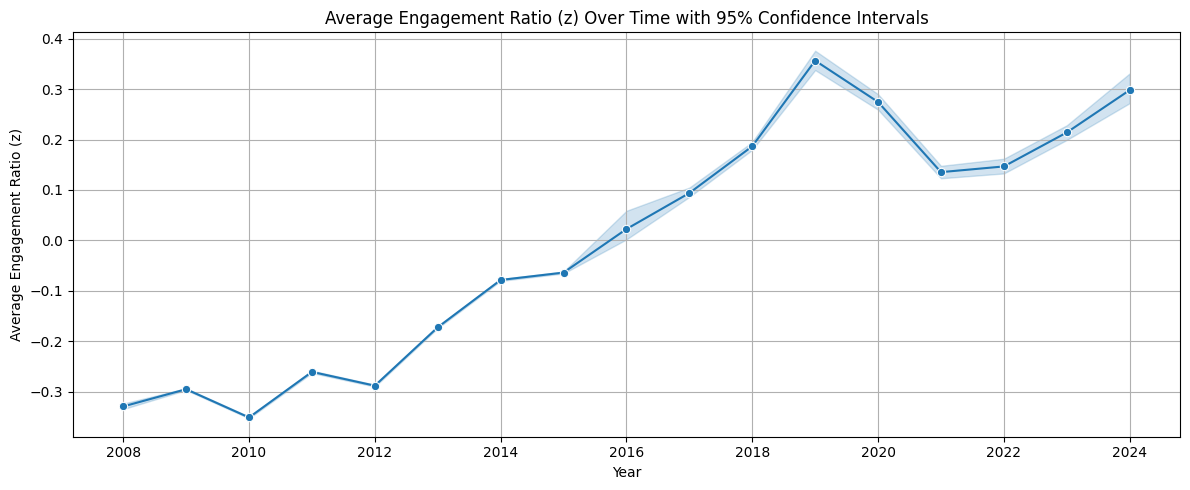

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'year' is numeric and clean data
df_clean = df.dropna(subset=["engagement_ratio_z", "year"]).copy()
df_clean["year"] = df_clean["year"].astype(int)

# Plot with bootstrapped confidence intervals
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_clean,
    x="year",
    y="engagement_ratio_z",
    estimator="mean",
    errorbar=('ci', 95),
    marker="o",
    err_style="band"
)
plt.title("Average Engagement Ratio (z) Over Time with 95% Confidence Intervals")
plt.xlabel("Year")
plt.ylabel("Average Engagement Ratio (z)")
plt.grid(True)
plt.tight_layout()
plt.show()


Upward Trend: There is a clear increase in engagement over time, particularly from around 2013 to 2019, where the average z-score rose from below -0.2 to over 0.35. This suggests that user interaction, as measured by upvotes per view, has become stronger over the years.

Peak and Plateau: The peak engagement occurs around 2019, followed by a modest decline and stabilization between 2020 and 2022. The slight dip in these years could reflect platform changes, shifts in content types, or audience behavior.

Recent Recovery: From 2022 to 2024, there’s a slight resurgence in engagement, though the confidence intervals begin to widen again, suggesting greater uncertainty, likely due to fewer videos in the most recent years.

Confidence Intervals: The shaded bands represent the 95% confidence intervals, showing variability in engagement per year. Narrower bands (e.g., 2014–2018) imply greater data reliability, likely due to more data points, while wider intervals (e.g., post-2021) suggest less certainty, probably due to fewer uploads in those years.

In [ ]:
# detect and quantify stereotypes in titles
df["has_stereotype"] = df["adj_noun_annotations"].apply(
    lambda anns: any(a["stereotype"] != "None" for a in anns)
)


In [101]:
df.has_stereotype.value_counts()

has_stereotype
False    234220
True      21906
Name: count, dtype: int64

In [102]:
#  Compare Engagement Across Stereotype Types
rows = []
for idx, anns in df["adj_noun_annotations"].items():
    for a in anns:
        if a["stereotype"] != "None":
            rows.append({
                "index": idx,
                "stereotype": a["stereotype"]
            })

df_stereo = pd.DataFrame(rows).merge(df[["engagement_ratio_z"]], left_on="index", right_index=True)
grouped = df_stereo.groupby("stereotype")["engagement_ratio_z"].describe()
print(grouped)


              count      mean       std       min       25%       50%  \
stereotype                                                              
age          4894.0  0.009572  1.464198 -0.521131 -0.177406 -0.049803   
body        16144.0 -0.001390  0.385279 -0.516585 -0.171760 -0.032656   
race           95.0 -0.070542  0.231660 -0.407847 -0.236603 -0.095812   
role         1535.0  0.012635  2.906688 -0.505880 -0.233516 -0.085414   

                 75%         max  
stereotype                        
age         0.097920   96.620743  
body        0.110122   22.062803  
race        0.042511    0.613243  
role        0.070348  113.391087  


Engagement by Stereotype Category

To assess how different types of stereotypical framings correlate with user engagement, we examined standardized engagement ratios (z-scores) for titles containing gendered stereotypes related to age, body, race, and role.

Descriptive statistics indicate that:

Body-related stereotypes were the most prevalent (n = 16,144), but showed a near-zero mean engagement (M = -0.0014, SD = 0.39), suggesting they are widespread but not particularly associated with enhanced user response.

Age-related stereotypes (e.g., references to "teen") were also common (n = 4,894), with slightly positive mean engagement (M = 0.0096, SD = 1.46), though the large standard deviation indicates high variability in user reactions.

Role-related stereotypes (e.g., "wife", "mom") had the highest average engagement (M = 0.0126, SD = 2.91), and a wide range (max = 113.39), implying these framings occasionally trigger unusually high user interaction.

Race-related stereotypes were rare (n = 95) and showed a negative mean engagement (M = -0.0705), with limited variation (SD = 0.23), potentially reflecting user aversion or platform moderation effects.

Together, these results suggest that stereotypes involving social roles and age may be more positively reinforced by user engagement, whereas race-related cues may be either underrepresented or less engaging on average. Body-related descriptors, while common, appear relatively neutral in terms of eliciting strong engagement.

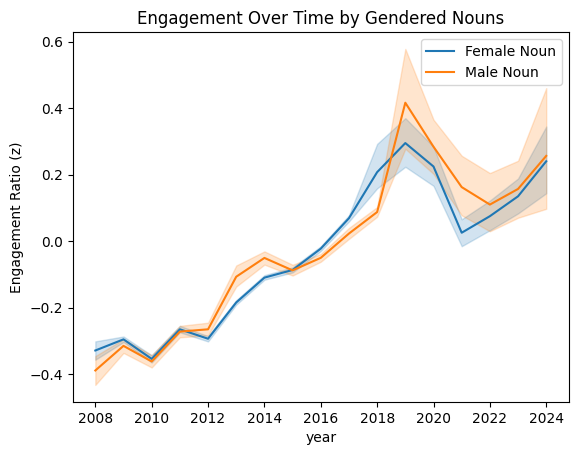

In [108]:
# the effect of gendered language has changed over time

sns.lineplot(data=df[df["has_female_noun"] == True], x="year", y="engagement_ratio_z", label="Female Noun")
sns.lineplot(data=df[df["has_male_noun"] == True], x="year", y="engagement_ratio_z", label="Male Noun")
plt.title("Engagement Over Time by Gendered Nouns")
plt.ylabel("Engagement Ratio (z)")
plt.show()



Results: To examine the relationship between gendered language and user engagement, we analyzed how the presence of female- or male-coded nouns in video titles predicted standardized engagement (z-scored upvote-to-view ratio) across time.

As shown in Figure X, engagement levels for both female- and male-referencing titles increased steadily from 2008 to 2019, peaking around 2019. Notably, the average engagement for titles containing male-coded nouns slightly surpassed that of female-coded nouns between 2018–2021, though both trends closely track one another overall.

Bootstrapped 95% confidence intervals suggest that while differences between male- and female-noun titles were generally small, they were most pronounced around the 2019 peak. After 2020, engagement slightly declined for both groups before rising again in recent years.

These patterns suggest that gendered lexical framing in video titles has become increasingly aligned with user engagement over time, with a modest but consistent preference for titles referencing male-coded entities during the period of peak platform activity.


R² score: 0.1268, RMSE: 0.4436


/tmp/ipykernel_20272/919302478.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")


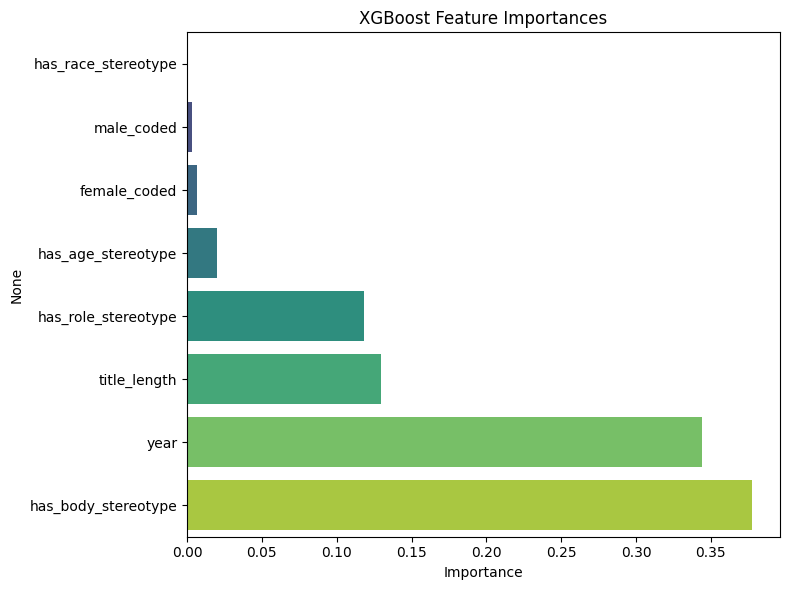

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare data ---
features = [
    "female_coded", "male_coded",
    "has_body_stereotype", "has_age_stereotype",
    "has_role_stereotype", "has_race_stereotype",
    "title_length", "year"
]
target = "engagement_ratio_z"

model_df = df[features + [target]].dropna()
X = model_df[features]
y = model_df[target]

# --- Step 2: Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Train XGBoost Model ---
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# --- Step 4: Evaluate Model ---
y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² score: {r2:.4f}, RMSE: {rmse:.4f}")

# --- Step 5: Feature Importance Plot ---
importances = xgb.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Methods

To assess the predictive contribution of linguistic bias and stereotype markers on user engagement, we trained an XGBoost regression model using standardized engagement ratio (engagement_ratio_z) as the dependent variable. Predictor variables included binary indicators for gendered language (female_coded, male_coded), four stereotype categories (has_body_stereotype, has_age_stereotype, has_role_stereotype, has_race_stereotype), as well as title_length and year as control variables. The model was trained on a random 80% train split, and performance was evaluated using R² and RMSE on the held-out test set.

Results

The XGBoost model explained approximately 12.7% of the variance in standardized engagement scores. Feature importance analysis indicated that has_body_stereotype and year were the strongest predictors of engagement, followed by title_length and has_role_stereotype. Gendered language indicators (female_coded, male_coded) and other stereotype categories (e.g., has_race_stereotype) contributed minimally to predictive power. These findings suggest that objectifying framings (e.g., body-based language) and temporal factors are more closely associated with engagement dynamics than gender coding alone.

In [ ]:
#HERE

#### Sentiment analysis


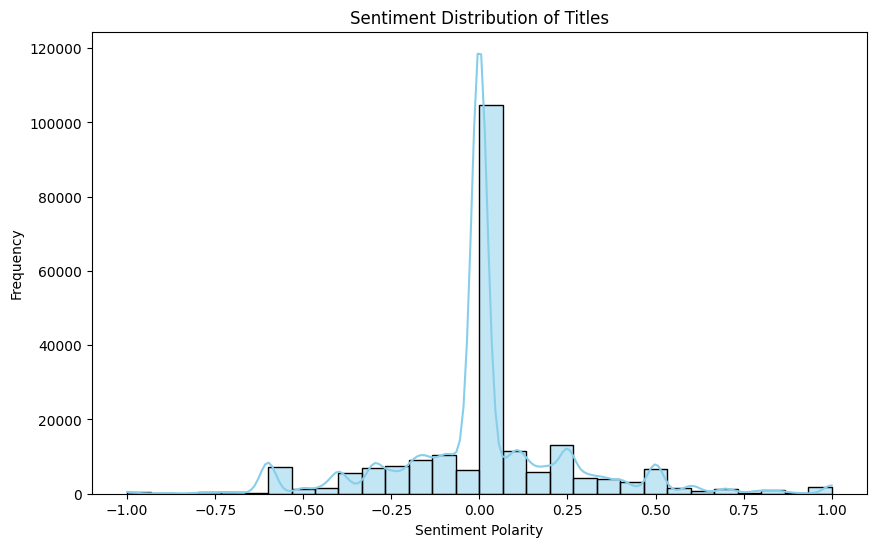

In [29]:
from textblob import TextBlob


# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


# Apply the function to the title column
df["sentiment"] = df["title"].apply(get_sentiment)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Distribution of Titles")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
output_plot_path = "plots/title_sentiment_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

# # Print some example titles with their sentiment scores
# print(df[["title", "sentiment"]].head(10))

In [38]:

# Other questions to explore
# see how most common bigramms and trigramms are related to views
# Add upvotes, downvotes and views dimension


#### N-grams 
Identify most common adjacent pairs 

Identify pairs of adjacent words in titles and see which are more prevalent in the dataset. N-grams capture more context than unigrams (single words) allowing for a better understandig of the relationship between words. They also allow to identify collocations (words that frequently appear together).


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


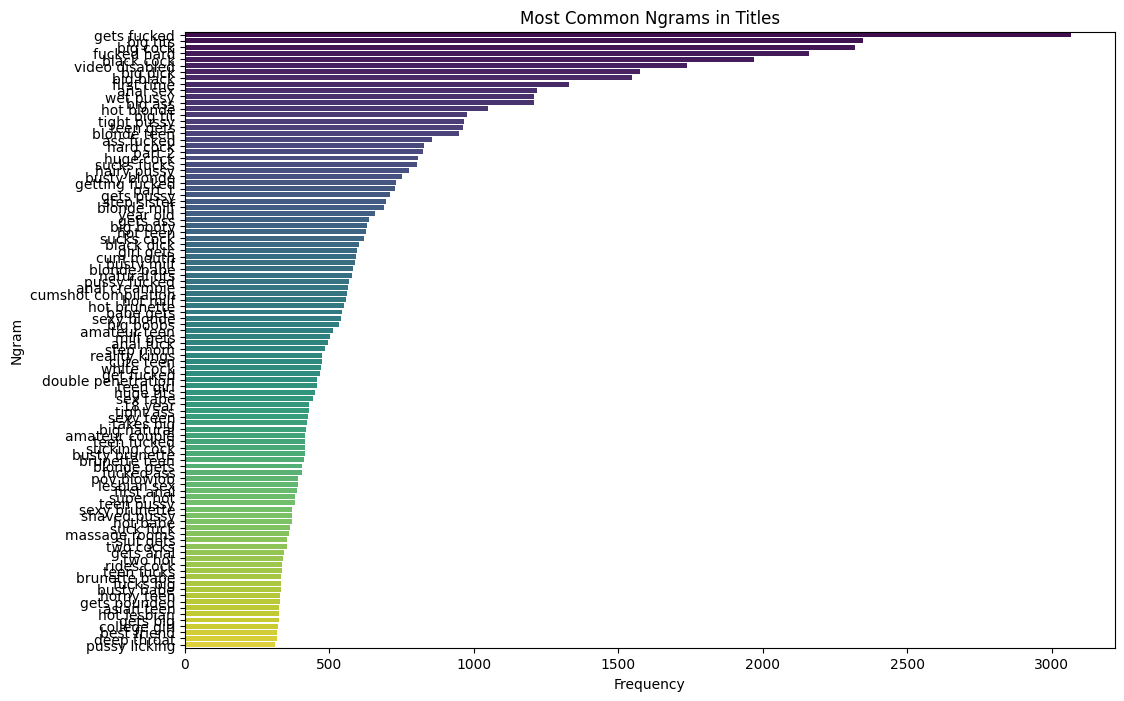

In [20]:
from nltk.util import ngrams
from src.models import embeddings

embeddings.download_nltk_data()

# Apply the function to the title column
df["title_words_token"] = df["title"].apply(embeddings.clean_and_tokenize)

# Generate bigrams
all_ngrams = [ngram for words in df["title_words_token"] for ngram in ngrams(words, 2)]

# Count the frequency of each bigram
ngram_counts = Counter(all_ngrams)

# Get the most common bigrams
most_common_ngrams = ngram_counts.most_common(100)

# Convert to DataFrame for plotting, converting bigrams to strings
ngram_freq_df = pd.DataFrame(most_common_ngrams, columns=["ngram", "count"])
ngram_freq_df["ngram"] = ngram_freq_df["ngram"].apply(lambda x: " ".join(x))

# Plot the most common bigrams
plt.figure(figsize=(12, 8))
sns.barplot(
    x="count",
    y="ngram",
    data=ngram_freq_df,
    hue="ngram",
    palette="viridis",
    legend=False,
)
plt.title("Most Common Ngrams in Titles")
plt.xlabel("Frequency")
plt.ylabel("Ngram")
output_plot_path = "plots/most_common_ngrams_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

In [22]:
ngram_freq_df.to_csv("data/processed/most_common_ngrams.csv", index=False)


#### Grammatical analysis --REVISE, mostly done above

- Indirect objects
- Active and passive subject, person or not e.g. body part
- adjective + subject What adjectives are more frequent with subjects e.g. hot chinese girl, and frequency distribution of adjectives and subjects
- context, place 
- verbs frequency


In [7]:
# import spacy
# # python -m spacy download en_core_web_sm
# # Load the English NLP model
# nlp = spacy.load("en_core_web_md")

# # # TODO need more thinking
# # # Function to extract indirect objects from a title
# # def extract_indirect_object(title):
# #     doc = nlp(title)
# #     indirect_objects = []

# #     for token in doc:
# #         # Check for indirect object (dative case) or preposition followed by a noun
# #         if token.dep_ == "iobj":
# #             indirect_objects.append(token.text)
# #         elif token.dep_ == "prep":  # Check for prepositions
# #             # Look for the object of the preposition
# #             for child in token.children:
# #                 if child.dep_ in [
# #                     "pobj",
# #                     "dobj",
# #                 ]:  # Object of the preposition or direct object
# #                     indirect_objects.append(child.text)

# #     return indirect_objects


# # # Apply the function to the titles in the DataFrame
# # df["indirect_object"] = df["title"].apply(extract_indirect_object)

# # # Display the results
# # df[["title", "indirect_object"]]


In [5]:
# # Subject active

# import spacy
# # python -m spacy download en_core_web_sm
# # Load the English NLP model
# nlp = spacy.load("en_core_web_sm")

# # subset the data
# df = df.head(1000)

# # Function to extract active subjects from a sentence
# def extract_active_subjects(sentence):
#     doc = nlp(sentence)
#     subjects = []

#     for token in doc:
#         # Check for nominal subjects (nsubj) and compound subjects
#         if token.dep_ == "nsubj":
#             subjects.append(token.text)
#         # Check for compound subjects
#         elif token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
#             for child in token.children:
#                 if child.dep_ == "conj":  # Check for conjunctions
#                     subjects.append(child.text)

#     # Remove duplicates and return
#     return list(set(subjects))

# # Apply the function to the titles in the DataFrame
# df["subject_active"] = df["title"].apply(extract_active_subjects)


In [4]:
# # Function to extract passive subjects from a sentence
# def extract_passive_subjects(sentence):
#     doc = nlp(sentence)
#     passive_subjects = []

#     for token in doc:
#         # Check if the token is a passive subject
#         if token.dep_ == "nsubjpass":
#             passive_subjects.append(token.text)
#         # Additionally, check for auxiliary verbs that indicate passive voice
#         elif token.dep_ == "auxpass":  # Auxiliary verb for passive voice
#             # Check if the head of the auxiliary verb is a verb in passive form
#             if token.head.dep_ == "VERB" and token.head.tag_ in [
#                 "VBN",
#                 "VBD",
#             ]:  # VBN: past participle, VBD: past tense
#                 # Get the subject of the passive construction
#                 for child in token.head.children:
#                     if child.dep_ == "nsubjpass":
#                         passive_subjects.append(child.text)

#     return passive_subjects


# # Apply the function to the titles in the DataFrame
# df["subject_pass"] = df["title"].apply(extract_passive_subjects)


In [ ]:
# # Flatten the list of active subjects and lemmatize while normalizing case
# all_active_subjects = []
# for sublist in df["subject_active"]:
#     for subject in sublist:
#         doc = nlp(subject)  # Tokenize and lemmatize
#         lemmatized_subjects = [
#             token.lemma_.lower() for token in doc
#         ]  # Get the lemmatized form and convert to lowercase
#         all_active_subjects.extend(
#             lemmatized_subjects
#         )  # Add lemmatized subjects to the list

# # Count the frequency of each subject
# subject_frequency = Counter(all_active_subjects)

# # Convert the frequency counts to a DataFrame
# frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

# # Sort the DataFrame by frequency in descending order
# frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# # Save the frequency DataFrame to a CSV file
# output_csv_path = "data/processed/active_subject_frequency_distribution.csv"
# frequency_df.to_csv(output_csv_path, index=False)


In [3]:
# # Create a bar chart for the top N subjects
# top_n = 20  # Change this to the number of top subjects you want to visualize
# plt.figure(figsize=(10, 6))
# plt.barh(
#     frequency_df["Subject"].head(top_n),
#     frequency_df["Frequency"].head(top_n),
#     color="skyblue",
# )
# plt.xlabel("Frequency")
# plt.ylabel("Subject")
# plt.title(f"Top {top_n} Active Subjects Frequency Distribution")
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
# output_plot_path = "plots/top_active_subjects_frequency_distribution.png"
# plt.savefig(output_plot_path, bbox_inches="tight")
# plt.show()


In [2]:
# # Flatten the list of passive subjects and lemmatize while normalizing case
# all_passive_subjects = []
# for sublist in df["subject_pass"]:
#     for subject in sublist:
#         doc = nlp(subject)  # Tokenize and lemmatize
#         lemmatized_subjects = [token.lemma_.lower() for token in doc]
#         all_passive_subjects.extend(lemmatized_subjects)

# subject_frequency = Counter(all_passive_subjects)

# frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

# frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# # Save the frequency DataFrame to a CSV file
# output_csv_path = "data/processed/passive_subject_frequency_distribution.csv"
# frequency_df.to_csv(output_csv_path, index=False)


In [1]:
# # Create a bar chart for the top N subjects
# top_n = 20

# plt.figure(figsize=(10, 6))
# plt.barh(
#     frequency_df["Subject"].head(top_n),
#     frequency_df["Frequency"].head(top_n),
#     color="skyblue",
# )
# plt.xlabel("Frequency")
# plt.ylabel("Subject")
# plt.title(f"Top {top_n} Passive Subjects Frequency Distribution")
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
# output_plot_path = "plots/top_passive_subjects_frequency_distribution.png"
# plt.savefig(output_plot_path, bbox_inches="tight")  # Save the figure with tight layout
# plt.show()
